In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,LinearSVR
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')


# 🔄 Data Science Lifecycle — Predicting Energy Demand

In this tutorial, we apply the **Data Science Lifecycle** to the task of **predicting electricity demand**.  
We will go step by step from business understanding to data preparation, modeling, and evaluation. 

The **Data Science Lifecycle** describes the structured process of solving problems with data.
It ensures that projects are systematic, reproducible, and lead to actionable insights.

---
## Data Science Lifecycle 
### 1️⃣ Business Understanding 💡

* Define the **problem** and **goals** clearly.
* Understand **why the problem matters** (business, technical, or societal value).

---

### 2️⃣ Data Collection 📥

* Identify and gather relevant data sources.
* Sources can include **sensors, databases, APIs, logs, open datasets**.
* Check data availability, licensing, and quality early.
* Example: load, weather, and calendar data for energy forecasting.

---

### 3️⃣ Data Cleaning 🧹

* Inspect and fix data issues: missing values, duplicates, inconsistent formats, outliers.
* Convert data types (timestamps, numerics).
* Create a **clean, reliable dataset** before analysis.

---

### 4️⃣ Data Exploration 🔎

* Explore data patterns with summary statistics and visualization.
* Identify distributions, correlations, and anomalies.
* Helps refine hypotheses and guides feature engineering.
* Example: look for daily, weekly, and seasonal cycles in demand.

---

### 5️⃣ Feature Engineering 🏗️

* Transform raw data into meaningful **features** for modeling.
* Techniques include:

  * **Lag features** (past values).
  * **Aggregates** (rolling averages, min/max).
  * **Calendar variables** (day of week, season, holiday).
  * **External drivers** (weather, events).
* Good features are often the **most important factor** for model success.

---

### 6️⃣ Modeling 🤖

* Choose appropriate modeling techniques:

  * **Baseline models** (persistence, averages).
  * **Statistical models** (ARIMA, ETS).
  * **Machine learning models** (regression, trees, neural networks).
* Train and tune models on historical data.
* Use proper **train-validation-test splits** (time-aware for time series).

---

### 7️⃣ Evaluation 📊

* Measure performance with appropriate metrics (MAE, RMSE, MAPE).
* Compare models against baselines.
* Evaluate not only global error but also **by segments** (hour of day, season).
* Visualize predictions vs actual values to interpret results.

---

### 8️⃣ Communication & Action 📢

* Translate results into insights for stakeholders.
* Highlight limitations, assumptions, and next steps.
* Deliver outputs in usable form (dashboards, reports, APIs, decision support).
* Example: provide day-ahead demand forecasts to system operators or market traders.

---

👉 This lifecycle is **iterative**: after evaluation, you may go back to adjust features, clean more data, or refine the business understanding.

---

## 📊 Data Science Lifecycle — Quick Guide

| Step                           | Question ❓                             | Output 📦                                 | Energy Example ⚡                          |
| ------------------------------ | -------------------------------------- | ----------------------------------------- | ----------------------------------------- |
| **1️⃣ Business Understanding** | What problem are we solving? Why?      | Clear problem statement, success criteria | Forecast demand to balance grid & market  |
| **2️⃣ Data Collection**        | What data do we need? Where to get it? | Raw datasets (logs, sensors, APIs)        | Load data from Elering + weather API      |
| **3️⃣ Data Cleaning**          | Is the data trustworthy?               | Clean, consistent dataset                 | Handle missing hours, fix timestamps      |
| **4️⃣ Data Exploration**       | What patterns do we see?               | Insights, plots, hypotheses               | Spot daily/weekly cycles, anomalies       |
| **5️⃣ Feature Engineering**    | How to represent the data for models?  | Feature set (lags, categories, external)  | Lag(24h), lag(168h), weekday, temperature |
| **6️⃣ Modeling**               | What methods can solve this?           | Trained models (baseline, ML, stats)      | ARIMA, Linear Regression, Random Forest   |
| **7️⃣ Evaluation**             | How good is the model?                 | Metrics, error analysis                   | Compare MAE, RMSE, MAPE vs baseline       |
| **8️⃣ Communication & Action** | How to deliver results?                | Reports, dashboards, decisions            | Day-ahead forecast to system operator     |




# 1️⃣ Business Understanding  

Predicting electricity demand is a **critical task in the energy sector**. Accurate forecasts help:

* ⚡ **Balance supply and demand**: system operators must match generation to consumption in real time.
* 💶 **Support energy markets**: demand forecasts influence day-ahead trading and price formation.
* 🌍 **Enable renewable integration**: with variable resources like wind and solar, knowing the expected demand is essential for stability.
* 🔋 **Optimize storage and flexibility**: storage systems, demand response, and flexible generation rely on reliable demand forecasts.

**The problem:**
We aim to build a **model that predicts short-term demand (e.g., next 24 hours)** based on historical data and relevant external drivers such as weather and calendar effects.

**Success criteria:**

* Forecasts should be **more accurate than a naïve baseline** (e.g., yesterday’s demand = today).
* Performance measured with metrics like **MAE, RMSE, and MAPE**.
* Forecasts must be **timely** (delivered ahead of the market deadlines).

---

**Our goal:** predict **next-day demand** using historical consumption data (and possibly weather/calendar features).  


# 2️⃣ Data Collection  📥

---

### 🐼 Quick Guide: `pandas.read_csv()`

`read_csv()` is the standard function to read tabular data from a **CSV (comma-separated values) file**.

```python
import pandas as pd

# Basic usage
df = pd.read_csv("energy_data.csv")

# Common useful options:
df = pd.read_csv(
    "energy_data.csv",
    sep=",",            # field separator ("," is default, ";" for some European files)
    parse_dates=["time"], # convert date column into datetime objects
    index_col="time"      # use a column (e.g., time) as index
)

print(df.head())
```

We first load the dataset. In practice, demand and production data can be obtained from several sources:

* **Elering** (Estonian transmission operator) → [System dashboard](https://dashboard.elering.ee/et/system/with-plan/production-consumption) provides historical demand and production.
* **CSV files or APIs** provided by operators, markets (e.g., Nord Pool), or weather services.
* **Other energy market datasets** (regional TSOs, open data portals, Kaggle, etc.).

Once downloaded (typically as a CSV), we can load the data into Python using **Pandas**.


✅ This will create a **DataFrame** where each column is a variable (e.g., demand, production) and each row is a timestamp.

---

### 📥 Raw energy demand data

In [2]:
elering = pd.read_csv('data/electricity-production and consumption_2022.csv',  delimiter=';',decimal=',')
elering

,Ajatempel (UTC),Kuupaev (Eesti aeg),Tarbimine,Tootmine,Planeeritud tarbimine,Planeeritud tootmine
0,1640988000,01.01.2022 00:00,899.4,419.5,903.1,462.4
1,1640991600,01.01.2022 01:00,892.1,431.9,935.8,469.1
2,1640995200,01.01.2022 02:00,874.3,428.1,897.6,458.6
3,1640998800,01.01.2022 03:00,860.1,435.7,878.5,471.9
4,1641002400,01.01.2022 04:00,842.7,429.2,891.1,472.2
...,...,...,...,...,...,...
8755,1672506000,31.12.2022 19:00,989.4,674.4,983.3,660.0
8756,1672509600,31.12.2022 20:00,932.5,614.2,957.5,600.3
8757,1672513200,31.12.2022 21:00,889.5,609.5,921.1,590.6
8758,1672516800,31.12.2022 22:00,846.5,585.2,864.6,568.2


### 🌦️ Weather Data

Electricity demand is strongly influenced by **weather conditions**:

* ❄️ Cold weather → higher heating demand.
* 🌞 Hot weather → higher cooling demand.
* 💨 Wind and ☁️ cloud cover also impact renewable generation.

For this project, we can use **historical weather data** from Tallinn Airport, available via:
👉 [Weather archive — Tallinn (airport), RP5](https://rp5.ru/Weather_archive_in_Tallinn_%28airport%29)

Typically, the downloaded file will include:

* Temperature (°C)
* Humidity (%)
* Wind speed (m/s)
* Cloud cover (0–8)
* Pressure, precipitation, etc.

In [3]:
weather = pd.read_csv('data/weather_2022.csv',  delimiter=';', decimal='.', index_col = False)
weather

,Local time in Tallinn (airport),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,31.12.2022 23:00,5.8,744.1,747.2,-0.7,93.0,Wind blowing from the south-southwest,3.0,NaN,NaN,...,NaN,NaN,35.0,4.8,0.1,3.0,NaN,NaN,NaN,NaN
1,31.12.2022 22:00,5.9,744.3,747.3,-0.5,93.0,Wind blowing from the south-west,4.0,9.0,10.0,...,NaN,NaN,35.0,4.8,0.2,3.0,NaN,NaN,NaN,NaN
2,31.12.2022 21:00,5.8,744.4,747.4,-0.3,93.0,Wind blowing from the south-southwest,4.0,8.0,NaN,...,NaN,NaN,35.0,4.8,0.2,3.0,NaN,NaN,NaN,NaN
3,31.12.2022 20:00,5.7,744.8,747.8,-0.5,94.0,Wind blowing from the south-west,4.0,9.0,NaN,...,NaN,NaN,35.0,4.8,0.5,12.0,NaN,NaN,NaN,NaN
4,31.12.2022 19:00,5.4,744.8,747.9,-0.8,96.0,Wind blowing from the south-west,4.0,8.0,NaN,...,NaN,NaN,20.0,4.8,0.3,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,01.01.2022 04:00,-0.1,748.8,751.9,0.5,100.0,Wind blowing from the north-east,2.0,NaN,NaN,...,NaN,NaN,0.9,-0.1,1.0,3.0,NaN,NaN,NaN,NaN
8728,01.01.2022 03:00,-0.1,748.5,751.6,0.4,99.0,Wind blowing from the north-east,1.0,NaN,NaN,...,NaN,NaN,0.4,-0.2,0.8,3.0,NaN,NaN,NaN,NaN
8729,01.01.2022 02:00,0.0,748.2,751.3,0.2,99.0,Wind blowing from the east,1.0,NaN,NaN,...,NaN,NaN,0.4,-0.1,0.5,3.0,NaN,NaN,NaN,NaN
8730,01.01.2022 01:00,-0.6,748.3,751.4,1.2,99.0,Wind blowing from the north-northwest,1.0,NaN,NaN,...,NaN,NaN,0.3,-0.7,0.2,3.0,NaN,NaN,NaN,NaN


# 3️⃣ Data Cleaning 🧹

Before analysis, the dataset must be **clean and consistent**. Typical steps include:

* 🕳️ **Handle missing values** → interpolate, fill with averages, or drop rows if necessary.
* ⏱️ **Convert timestamps** → make sure the time column is in `datetime` format.
* 🔢 **Ensure numeric columns** → demand/production should be floats or integers, not strings.
* 🚩 **Remove or correct outliers** → abnormal spikes (e.g., due to sensor errors) should be flagged.

---

### 📐 Indexing

In time series forecasting, it is very helpful to use **timestamps as the index** of the DataFrame:

```python
df["time"] = pd.to_datetime(df["time"])   # convert column to datetime
df = df.set_index("time")                 # set as index
df = df.asfreq("H")                       # ensure fixed hourly frequency
```

✅ Now you can easily slice data like:

```python
df.loc["2023-01"]        # all of January 2023
df.loc["2023-01-10":"2023-01-20"]  # specific period
```

---

### 🔎 Quick Look: `.info()`

The `.info()` method gives a concise summary of the DataFrame:

```python
df.info()
```

Output shows:

* Number of rows and columns
* Column names and data types (`int64`, `float64`, `datetime64`, `object`)
* Non-null counts (useful for spotting missing values)

✅ Example:

```
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   demand   8760 non-null   float64
 1   temp     8735 non-null   float64
```

Here we see:

* Demand has no missing values.
* Temperature has 25 missing values → must be handled before modeling.

---

👉 **Clean indexing + `.info()` checks** give confidence that the dataset is ready for deeper exploration.

In [4]:
elering['timestamp'] = pd.to_datetime(elering['Kuupaev (Eesti aeg)'], dayfirst=True)

In [5]:
elering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Ajatempel (UTC)        8760 non-null   int64         
 1   Kuupaev (Eesti aeg)    8760 non-null   object        
 2   Tarbimine              8760 non-null   float64       
 3   Tootmine               8760 non-null   float64       
 4   Planeeritud tarbimine  8760 non-null   float64       
 5   Planeeritud tootmine   8760 non-null   float64       
 6   timestamp              8760 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 479.2+ KB


In [6]:
weather['timestamp'] = pd.to_datetime(weather['Local time in Tallinn (airport)'], dayfirst=True)

In [7]:
temperature = weather[['timestamp', 'T']]
temperature.set_index('timestamp', inplace=True)
temperature

,T
timestamp,
2022-12-31 23:00:00,5.8
2022-12-31 22:00:00,5.9
2022-12-31 21:00:00,5.8
2022-12-31 20:00:00,5.7
2022-12-31 19:00:00,5.4
...,...
2022-01-01 04:00:00,-0.1
2022-01-01 03:00:00,-0.1
2022-01-01 02:00:00,0.0


In [8]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8732 entries, 2022-12-31 23:00:00 to 2022-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       8732 non-null   float64
dtypes: float64(1)
memory usage: 136.4 KB


In [9]:
demand = elering[['timestamp', 'Tarbimine']]
demand.set_index('timestamp', inplace=True)
demand = demand.rename(columns = {'Tarbimine':'demand'})

demand.head()

,demand
timestamp,
2022-01-01 00:00:00,899.4
2022-01-01 01:00:00,892.1
2022-01-01 02:00:00,874.3
2022-01-01 03:00:00,860.1
2022-01-01 04:00:00,842.7


In [10]:
planned_demand = elering[['timestamp', 'Planeeritud tarbimine']]
planned_demand.set_index('timestamp', inplace=True)
planned_demand = planned_demand.rename(columns = {'Planeeritud tarbimine':'planned_demand'})
planned_demand.head()

,planned_demand
timestamp,
2022-01-01 00:00:00,903.1
2022-01-01 01:00:00,935.8
2022-01-01 02:00:00,897.6
2022-01-01 03:00:00,878.5
2022-01-01 04:00:00,891.1


# 4️⃣ Data Exploration 🔎

Once the dataset is clean, the next step is to **explore patterns in demand**. This helps us understand the dynamics before building models.

We look for:

* 📅 **Daily and weekly cycles** → demand usually peaks in the morning and evening, and weekdays are often similar to each other.
* ❄️ **Seasonal variations** → winter weeks have higher demand due to heating, while summer weeks show lower demand and sometimes different daily profiles.
* 🏖️ **Holidays and special days** → these break the regular pattern. For example, a weekday holiday may look more like a weekend, reducing industrial and office demand.

---

## 📅  Let's look for patterns

* **Working days** are very similar to each other, with stable daily patterns.
* **Two consecutive weeks** often look almost identical, showing strong weekly seasonality.
* **Winter vs summer** → weekly demand profiles differ:

  * Winter shows **higher peaks and more pronounced daily variation**.
  * Summer shows **flatter curves and lower overall levels**.
* **Holidays ruin the pattern** → a holiday in the middle of a week disrupts the typical weekday cycle, making that day look like a weekend.

---

👉 These insights are crucial:

* They confirm the need for **calendar features** (weekday, holiday flags).
* They justify adding **seasonal terms** (month, temperature) to the model.
* They highlight the importance of **handling anomalies** like holidays separately.


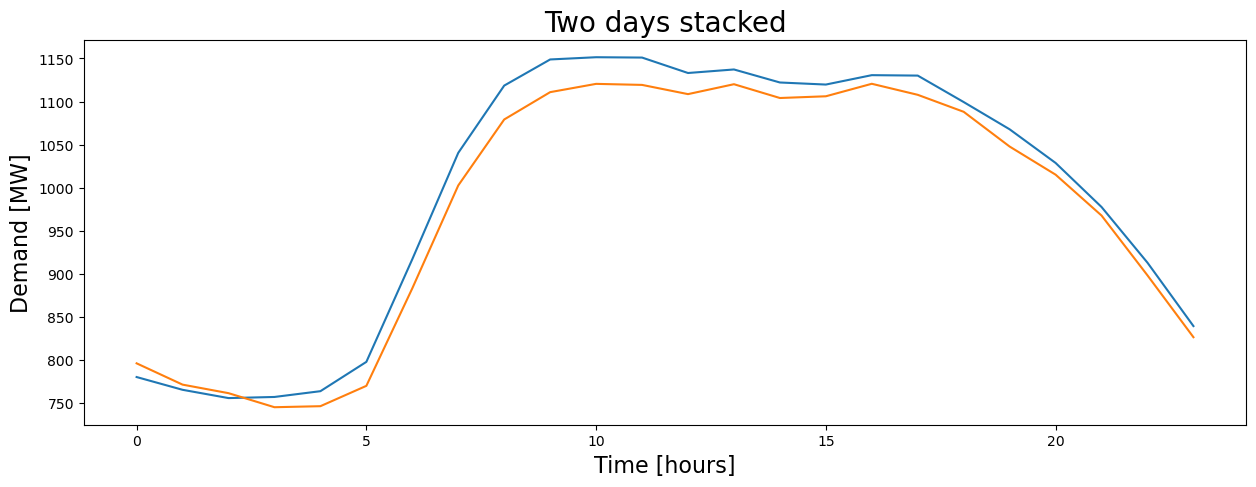

In [11]:
selection1 = demand.loc["2022-11-14"]
selection1.reset_index(inplace=True)

selection2 = demand.loc["2022-11-15"]
selection2.reset_index(inplace=True)

plt.figure(figsize=(15,5))
plt.title("Two days stacked", fontsize = 20)
p = sns.lineplot(data = selection1['demand'])
p = sns.lineplot(data = selection2['demand']);
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

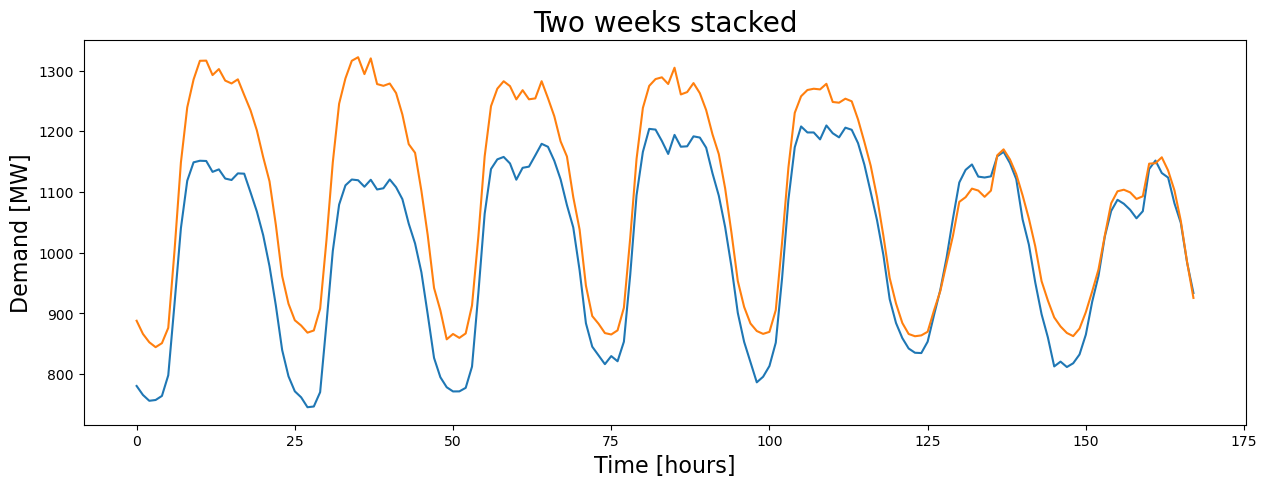

In [12]:
selection1 = demand.loc["2022-11-14":"2022-11-20"]
selection1.reset_index(inplace=True)

selection2 = demand.loc["2022-11-21":"2022-11-27"]
selection2.reset_index(inplace=True)



plt.figure(figsize=(15,5))
plt.title("Two weeks stacked", fontsize = 20)
p = sns.lineplot(data = selection1['demand'])
p = sns.lineplot(data = selection2['demand']);
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

## ❄️ Different seasons

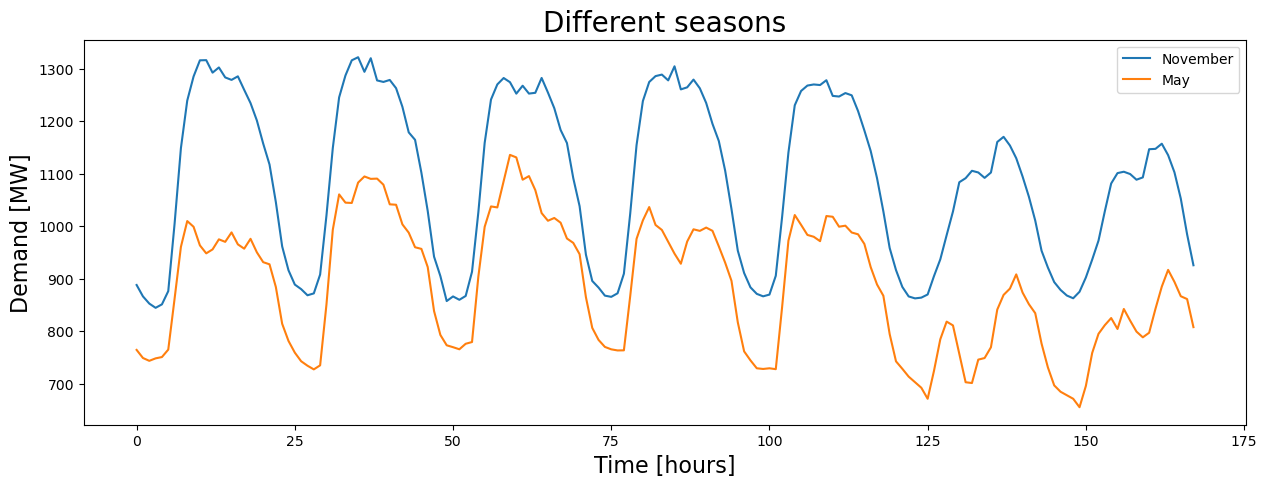

In [13]:
selection1 = demand.loc["2022-5-2":"2022-5-8"]
selection1.reset_index(inplace=True)

selection2 = demand.loc["2022-11-21":"2022-11-27"]
selection2.reset_index(inplace=True)


plt.figure(figsize=(15,5))
plt.title("Different seasons", fontsize = 20)
p = sns.lineplot(data = selection2['demand'], label="November")
p = sns.lineplot(data = selection1['demand'], label="May")

p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

## 🏖️ What can ruin the pattern?

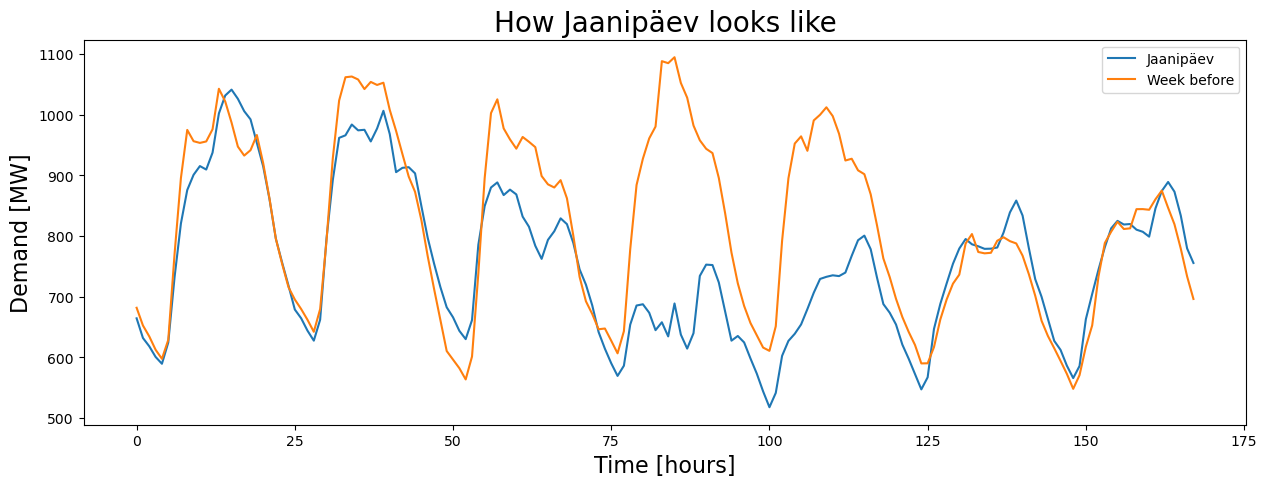

In [14]:
selection1 = demand.loc["2022-6-20":"2022-6-26"]
selection1.reset_index(inplace=True)

selection2 = demand.loc["2022-6-13":"2022-6-19"]
selection2.reset_index(inplace=True)

plt.figure(figsize=(15,5))
plt.title("How Jaanipäev looks like", fontsize = 20)
p = sns.lineplot(data = selection1['demand'], label="Jaanipäev")
p = sns.lineplot(data = selection2['demand'], label="Week before")
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

# 5️⃣ Feature Engineering 🏗️

Raw demand values alone are often not enough for accurate forecasting.
We add **features** that capture the main drivers of electricity consumption.

---

### 📅 Calendar Features

Demand patterns are **time-dependent**:

* **Hour of day** → captures daily cycles (morning/evening peaks, nighttime lows).
* **Day of week** → weekdays are usually similar, weekends have lower industrial demand.
* **Month/season** → heating demand in winter ❄️, cooling in summer 🌞.
* **Holiday flag** → holidays break the normal cycle 🏖️ (a weekday may look like a weekend).

👉 These features help the model distinguish *regular cycles* and *special cases*.

---


## ⏪ Lag Features — Why They Matter

Electricity demand has strong **temporal dependencies**:

* Demand at a given hour is closely related to the **same hour yesterday** (daily cycle).
* It is also related to the **same hour last week** (weekly cycle).
* Demand does not change randomly — it follows predictable **autocorrelation patterns**.

👉 Lag features help the model **remember the past** and exploit these correlations.

---

### ⚡ Common Lag Features

1. **Short-term lags**

   * `t-1`, `t-2`, … `t-24`
   * Capture immediate momentum (what just happened).
   * Example: if demand spiked at 18:00 today, 19:00 will also likely be high.

2. **Daily lags**

   * `t-24` (same hour yesterday).
   * Captures daily seasonality (work schedules, household routines).

3. **Weekly lags**

   * `t-168` (same hour last week).
   * Captures weekly seasonality (weekdays vs weekends).

---

### 🚨 Things to Watch Out For

* **Missing values:** when you shift the series, the first rows become `NaN`. These must be dropped before training.
* **Data leakage:** only use lags that are truly **in the past** relative to the prediction horizon. For day-ahead forecasting, use lags up to `t-24` but not closer.
* **Too many lags:** adding dozens of raw lag features can create noise and collinearity — pick the most relevant ones or use rolling stats.

---

👉 In **energy forecasting**, lag features form the **baseline models** themselves (persistence forecasts).
Better models (ML or statistical) usually start with lag features, then add calendar and weather information on top.

In [15]:
# lag7 is the data 7 days ago
y_features = demand.copy()
demand_lag7 = y_features[['demand']].shift(24*7)
demand_lag7 = demand_lag7.rename(columns = {'demand':'lag7'})
y_features = y_features.join(demand_lag7)

# lag2 is the data 2 days ago
demand_lag2 = y_features[['demand']].shift(24*2)
demand_lag2 = demand_lag2.rename(columns = {'demand':'lag2'})
y_features  = y_features .join(demand_lag2)

y_features  = y_features .dropna()  # drop rows with NaN from lagging
y_features 

,demand,lag7,lag2
timestamp,,,
2022-01-08 00:00:00,1004.3,899.4,928.8
2022-01-08 01:00:00,982.6,892.1,899.1
2022-01-08 02:00:00,962.7,874.3,889.3
2022-01-08 03:00:00,960.8,860.1,881.9
2022-01-08 04:00:00,955.1,842.7,891.3
...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1
2022-12-31 20:00:00,932.5,982.7,1077.0
2022-12-31 21:00:00,889.5,965.4,1031.4



## 🌦️ External Features: Weather

Electricity demand is not only driven by **time-based cycles** (calendar and lags) — it is also heavily influenced by **external factors**, the most important of which is **weather**.

---

### 🌡️ Temperature

* **Cold weather** → increases heating demand (electric heating, heat pumps).
* **Hot weather** → increases cooling demand (air conditioning, ventilation).
* This creates a **U-shaped relationship**: demand rises in both very low and very high temperatures.
* ⚡ **In this example:** we will focus on **temperature** as our main weather feature.

---

### 🔎 Why Weather Features Matter

* Calendar + lag features capture **internal patterns**,
* Weather features add **external drivers** that explain variation when patterns break (e.g., unusually cold weekend).

👉 **In this notebook:**
We will include **temperature** from Tallinn Airport as an external feature.
Later, this will allow us to model how heating and cooling demand changes with seasons, beyond just daily or weekly cycles.


In [16]:
y_features  = y_features .join(temperature)

In [17]:
y_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8593 entries, 2022-01-08 00:00:00 to 2022-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  8593 non-null   float64
 1   lag7    8593 non-null   float64
 2   lag2    8593 non-null   float64
 3   T       8564 non-null   float64
dtypes: float64(4)
memory usage: 335.7 KB


----
### 🛠️ Handling Missing Weather Data

Our `y_features` DataFrame has **temperature values (`T`)** alongside demand and lag features.
When we check `.info()`, we see that `T` has slightly fewer non-null values (8564 vs 8593 rows) → meaning there are **missing weather observations**.

* **`.fillna(method='bfill')`** → fills missing values by **backward filling** (taking the next valid observation).
* **`inplace=True`** → applies the change directly to the DataFrame without creating a copy.
* After this step, all rows have complete values, ensuring models don’t break when training.

---

👉 **Why it matters:** Most ML/statistical models cannot handle `NaN`s. Filling ensures the dataset is complete.
For weather, **backward/forward filling** is often acceptable because temperature changes smoothly over time.



In [18]:
y_features['T'].fillna(method='bfill', inplace=True)
y_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8593 entries, 2022-01-08 00:00:00 to 2022-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  8593 non-null   float64
 1   lag7    8593 non-null   float64
 2   lag2    8593 non-null   float64
 3   T       8593 non-null   float64
dtypes: float64(4)
memory usage: 335.7 KB


In [19]:
y_features  = y_features .join(planned_demand)
y_features

,demand,lag7,lag2,T,planned_demand
timestamp,,,,,
2022-01-08 00:00:00,1004.3,899.4,928.8,-8.9,1088.1
2022-01-08 01:00:00,982.6,892.1,899.1,-10.2,1068.4
2022-01-08 02:00:00,962.7,874.3,889.3,-10.4,1058.9
2022-01-08 03:00:00,960.8,860.1,881.9,-10.9,1049.5
2022-01-08 04:00:00,955.1,842.7,891.3,-10.3,1064.9
...,...,...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1,5.4,983.3
2022-12-31 20:00:00,932.5,982.7,1077.0,5.7,957.5
2022-12-31 21:00:00,889.5,965.4,1031.4,5.8,921.1



## 🧮 Transformations & Encodings

* **Cyclic encoding** for hour and weekday → use `sin()`/`cos()` so that 23:00 and 00:00 are close.
* **Non-linear transformations** → e.g., `temp^2` to capture U-shaped heating/cooling effects.
* **Categorical encoding** → one-hot encode weekdays, holidays, or regions.

---

👉 Good feature engineering is often **more important than model choice**.
It provides the **signal** the model needs to learn patterns hidden in raw data.


---

# 6️⃣ Modeling 🤖

At this stage, we try different approaches to **predict electricity demand**.

* **Baseline models** → very simple, like saying *“tomorrow’s demand = yesterday’s demand”*. These persistence models are important references — every advanced model must beat them.
* **Statistical models** → e.g., ARIMA, exponential smoothing. They explicitly model trends and seasonality.
* **Machine learning models** → e.g., linear regression, tree-based methods, or neural networks. These can capture more complex, nonlinear relationships.

👉 We always **start with a baseline model** to establish a **minimum performance benchmark** before moving to more advanced methods.

## 🧪 Training/Testing Data Split

To evaluate our model, we need to split the dataset into:

* **Training data** → past values the model learns from.
* **Testing data** → future values the model has never seen, used to measure accuracy.

In this simplified example:

* We forecast **only one day** (`2022-11-04`).
* Training period = the **previous 30 days**.
* No cross-validation is applied here (though it is common in time series to use rolling or expanding windows).

---

👉 In practice, we would use **rolling forecasts** or **cross-validation** for more robust evaluation, but this setup is enough for a first test.

In [20]:
predict_for_start = datetime.datetime(2022,11,4)
predict_for_end = predict_for_start + datetime.timedelta(days = 1)

training_end = predict_for_start - datetime.timedelta(days = 1)
training_start = training_end - datetime.timedelta(days = 30)

testing_vector = y_features[(y_features.index >= predict_for_start) &  (y_features.index < predict_for_end)]
training_vector = y_features[(y_features.index >= training_start) &  (y_features.index < training_end)]

## 🔎 Initial Comparison: Planned vs Actual

System operators often publish a **planned (forecasted) demand** for the next day.
We can compare this with the **actual demand** to see:

* How accurate the operator’s forecasts are.
* Whether our own models can do better.

One common evaluation metric is **MAPE (Mean Absolute Percentage Error)**:

$$
MAPE = \frac{100}{n} \sum \left| \frac{y - \hat{y}}{y} \right|
$$

where:

* $y$ = actual demand
* $\hat{y}$ = forecast (planned or model prediction)
* $n$ = number of observations

✅ **Why MAPE?**

* It expresses error in **percentages**, which makes it intuitive.
* Example: *MAPE = 5% means on average the forecast is off by 5% compared to actual demand.*


MAPE: 2.418


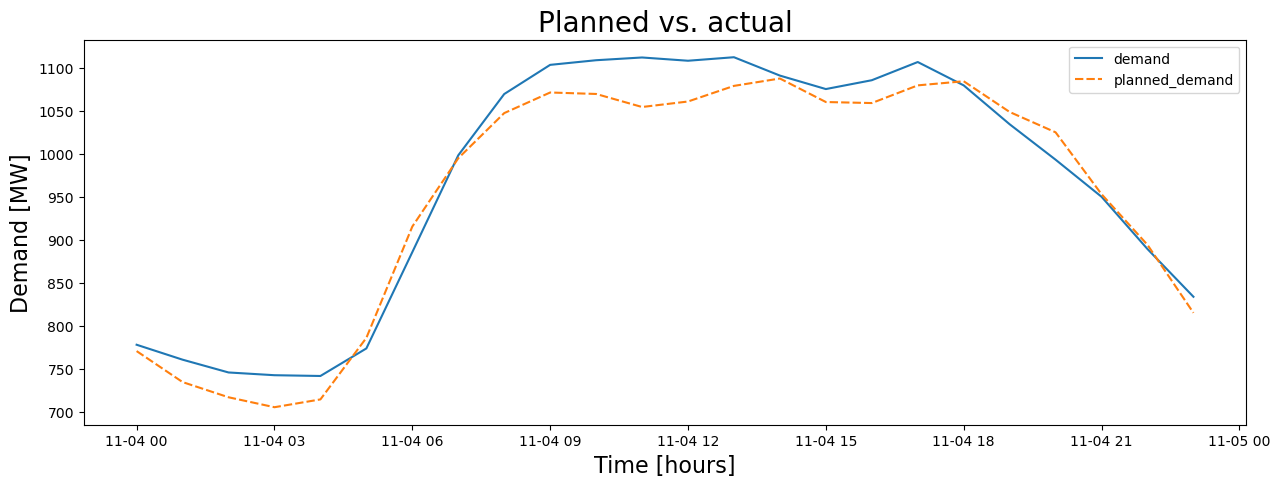

In [21]:
plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = testing_vector[['demand','planned_demand']]);
plt.title("Planned vs. actual", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

mape = mean_absolute_percentage_error(testing_vector['demand'], testing_vector['planned_demand'])*100
print("MAPE: %.3f" % mape)

results = {
    "Planned vs.actual": {"MAPE": mape}
}

---

## 🪞 Naive Model: Lag 7 (Same Day Last Week)

A simple but surprisingly strong baseline for electricity demand forecasting is the **seasonal naïve model**:

* **Idea:** *“Today’s demand will be the same as exactly one week ago.”*
* Why 7 days? Electricity demand has a **strong weekly seasonality** — working days look alike, and weekends differ.
* This model often performs reasonably well and sets a **benchmark** that more advanced models must beat.

👉 In practice, we just shift the demand series by **7 days (168 hours)** and use it as the prediction.
Then we compare the shifted values with the actual demand on the target day.

✅ If our advanced models cannot beat this baseline, they are not adding value!


MAPE: 1.552


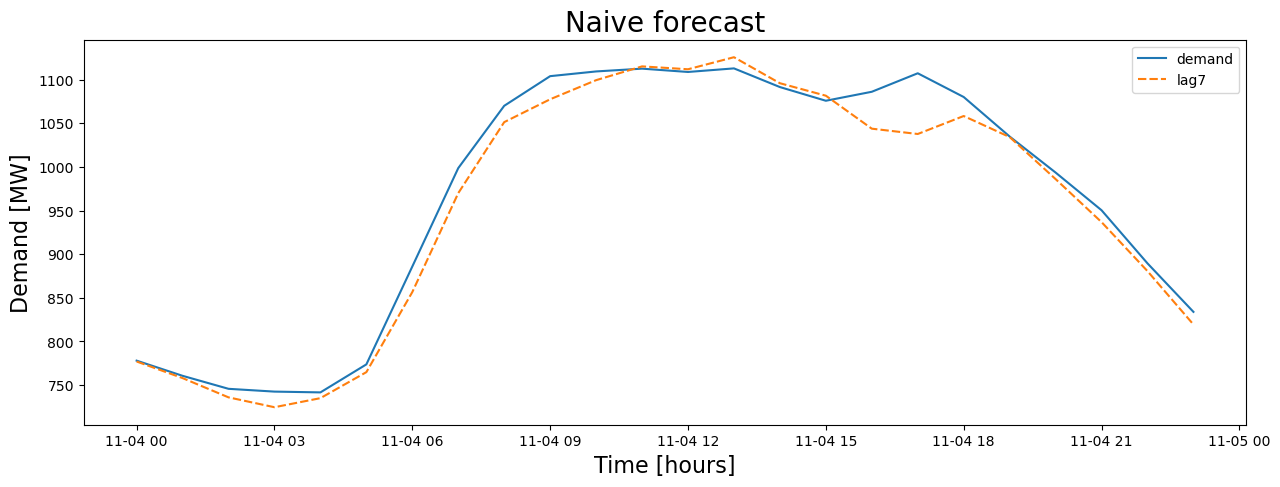

In [22]:
plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = testing_vector[['demand','lag7']]);
plt.title("Naive forecast", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);


mape = mean_absolute_percentage_error(testing_vector['demand'], testing_vector['lag7'])*100
print("MAPE: %.3f" % mape)

# Add a new row (new model result)
results["Naive model"] = {"MAPE": mape}


## 📈 Linear Regression

To move beyond the naïve baseline, we can use a **linear regression model**:

* **Idea:** predict demand as a **linear combination of features** (e.g., lag values, temperature).
* Unlike the lag-7 model, regression can **combine multiple signals**:

  * **Lag features** → yesterday’s demand, same hour last week.
  * **Calendar features** → hour of day, day of week.
  * **External features** → temperature, holidays.
* The model assigns **weights** to each feature, estimating how strongly it contributes to demand.

👉 Linear regression is simple, fast, and interpretable — making it a good **first step** beyond naïve forecasting.
It helps us see whether combining features provides clear improvements over the lag-only models.

---

### 📈 What is Linear Regression?

**Linear regression** is one of the simplest and most widely used statistical models.

* It tries to explain the relationship between a **dependent variable** (e.g., electricity demand) and one or more **independent variables** (features such as lagged demand or temperature).
* The model assumes this relationship is approximately **linear**:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
$$

where:

* $y$ = demand (target)
* $x_i$ = features (e.g., lag7, temperature)
* $\beta_i$ = coefficients (weights learned by the model)
* $\epsilon$ = error term

---

### 🔗 What is Correlation?

* **Correlation** measures how strongly two variables move together.
* Value ranges from **-1 to +1**:

  * +1 → perfect positive relationship (as one increases, so does the other).
  * -1 → perfect negative relationship (as one increases, the other decreases).
  * 0 → no linear relationship.
* Example: demand and temperature often show a **negative correlation in winter** (colder days → higher demand).


---

👉 Linear regression is a first step to quantify relationships. If patterns are non-linear (like U-shape demand vs temperature), we can **add polynomial features** (e.g., temp²) or move to more advanced models.

### Single feature: lag7

---

#### 📉 Graph with Regression Line

We can visualize linear regression by plotting data points and a **best-fit line**

✅ This plot shows:

* Each point = demand vs. lag7.
* The red line = regression line → best linear fit.

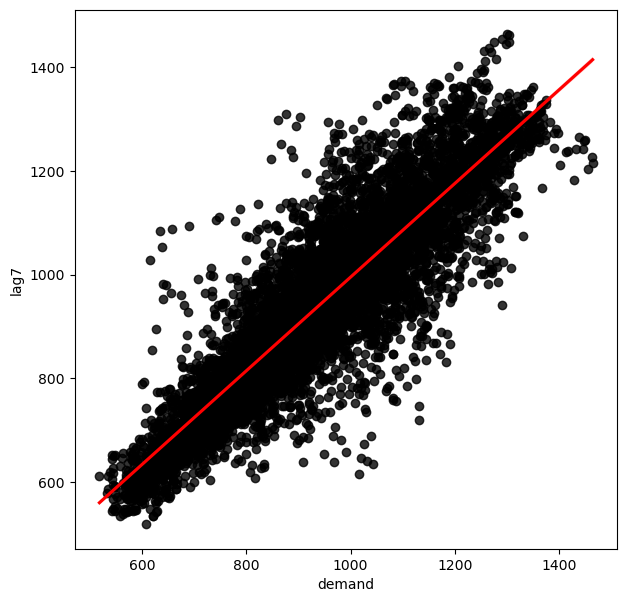

In [23]:
plt.figure(figsize=(7,7))
sns.regplot(x='demand',y='lag7',data=y_features,  scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [24]:
X_test = testing_vector[['lag7']]
y_test = testing_vector[['demand']]

X_train = training_vector[['lag7']]
y_train = training_vector[['demand']]

MAPE: 1.794


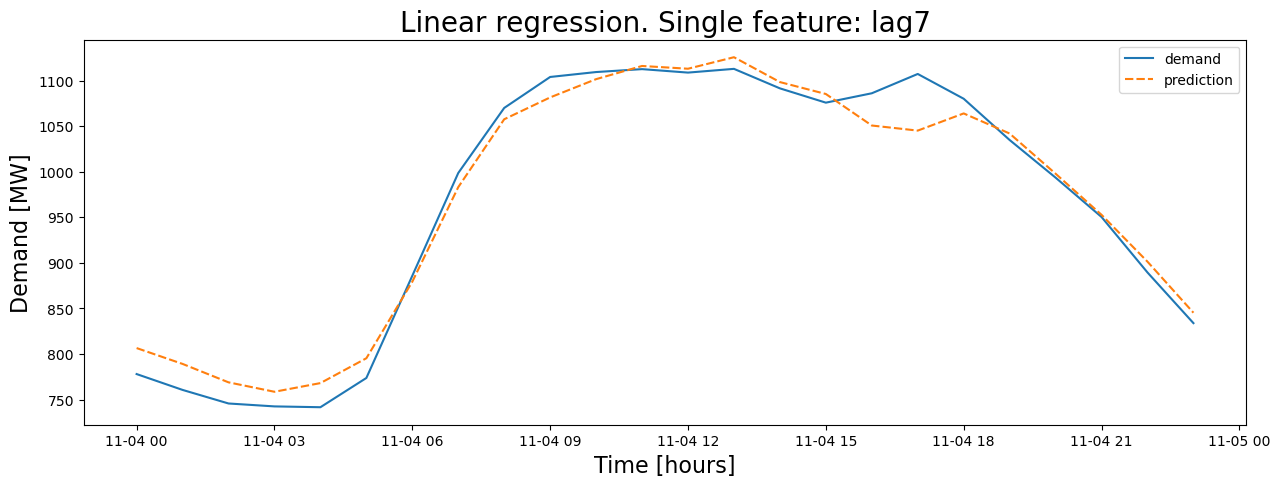

In [25]:
model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Linear regression. Single feature: lag7", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);


mape = mean_absolute_percentage_error(y_test, predictions_vector)*100
print("MAPE: %.3f" % mape)

# Add a new row (new model result)
results["Linear regression on lag7"] = {"MAPE": mape}


### Features: lag7 and lag2

In [26]:
X_test = testing_vector[['lag7', 'lag2']]
y_test = testing_vector[['demand']]

X_train = training_vector[['lag7', 'lag2']]
y_train = training_vector[['demand']]

MAPE: 1.352


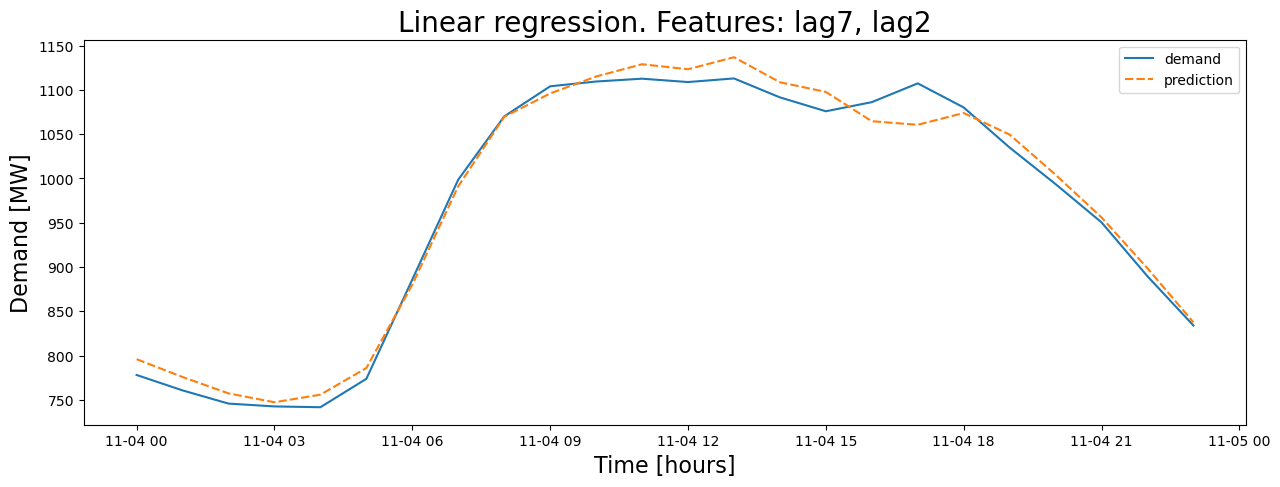

In [27]:
model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Linear regression. Features: lag7, lag2", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

mape = mean_absolute_percentage_error(y_test, predictions_vector)*100
print("MAPE: %.3f" % mape)

# Add a new row (new model result)
results["Linear regression on lag7, lag2"] = {"MAPE": mape}

### Features: lag7, lag2, temperature

In [28]:
X_test = testing_vector[['lag7', 'lag2', 'T']]
y_test = testing_vector[['demand']]

X_train = training_vector[['lag7', 'lag2', 'T']]
y_train = training_vector[['demand']]

MAPE: 2.338


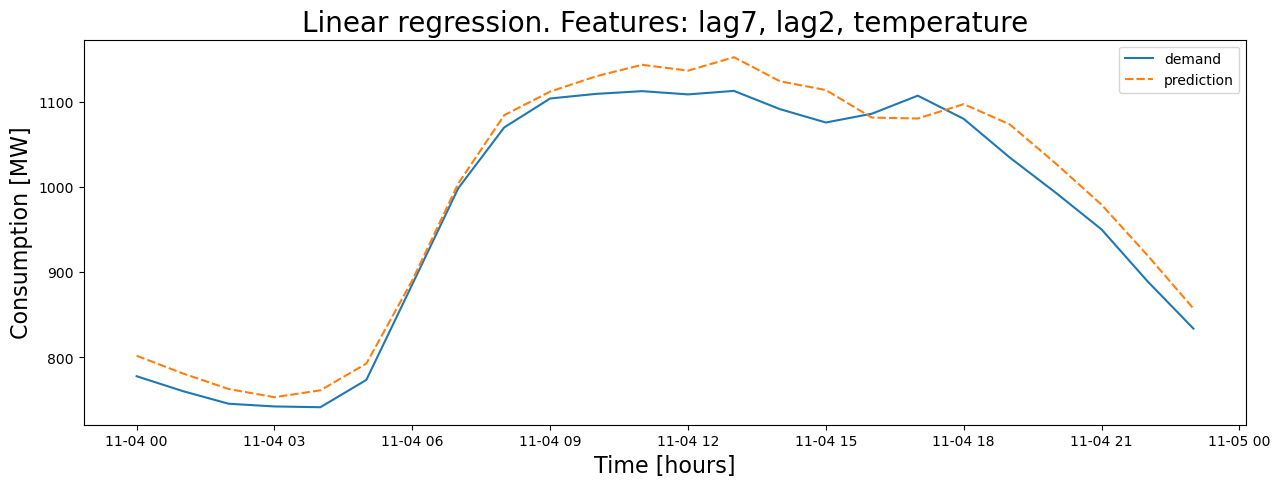

In [29]:
model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Linear regression. Features: lag7, lag2, temperature", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

mape = mean_absolute_percentage_error(y_test, predictions_vector)*100
print("MAPE: %.3f" % mape)

# Add a new row (new model result)
results["Linear regression on lag7, lag2, temperature"] = {"MAPE": mape}

---

## ⚙️ Support Vector Regression (SVR)

**Support Vector Regression (SVR)** is an extension of Support Vector Machines (SVM) for regression tasks.

* Instead of fitting a line through all points (like linear regression), SVR tries to find a **function that fits the data within a margin of tolerance (ε)**.
* It is powerful for capturing **non-linear relationships**, especially when combined with kernels (e.g., RBF kernel).
* SVR works well on **medium-sized datasets** but can be slower on very large time series.

👉 In energy demand forecasting, SVR can model complex effects (like the non-linear relation between demand and temperature) that linear regression may miss.

✅ Key differences vs Linear Regression:

* Linear regression minimizes squared errors.
* SVR ignores small errors within the ε margin and focuses on keeping predictions within a “tube” around actual values.

### Single feature lag 7

In [30]:
X_test = testing_vector[['lag7']]
y_test = testing_vector[['demand']]

X_train = training_vector[['lag7']]
y_train = training_vector[['demand']]

MAPE: 6.258


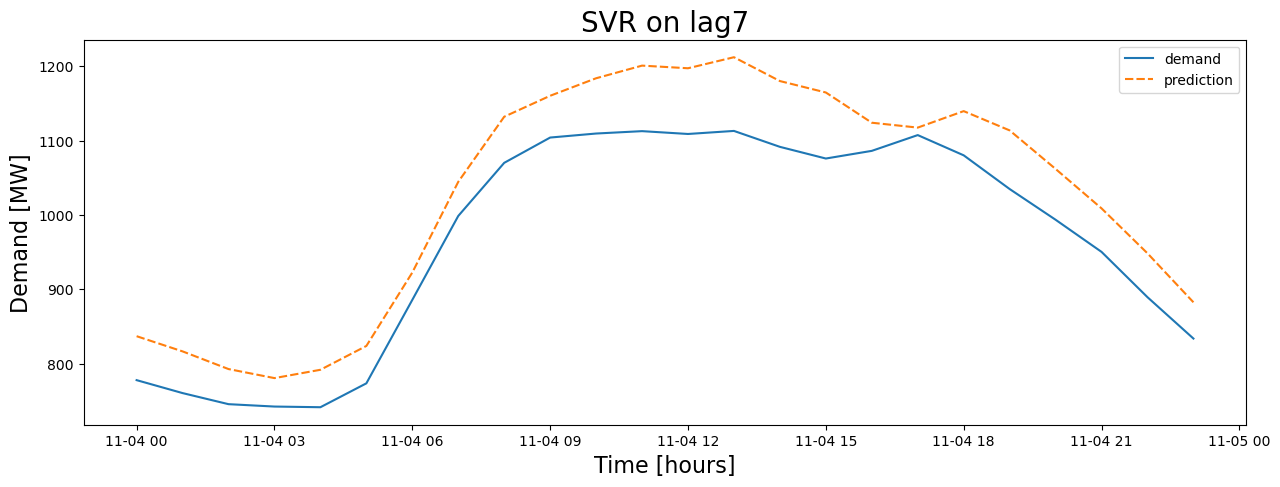

In [31]:
model = LinearSVR()
model.fit(X_train,y_train.values.ravel())

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("SVR on lag7", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

mape = mean_absolute_percentage_error(y_test, predictions_vector)*100
print("MAPE: %.3f" % mape)

# Add a new row (new model result)
results["SVR on lag7"] = {"MAPE": mape}

### Two features: lag7, lag2

In [32]:
X_test = testing_vector[['lag7', 'lag2']]
y_test = testing_vector[['demand']]

X_train = training_vector[['lag7', 'lag2']]
y_train = training_vector[['demand']]

MAPE: 4.223


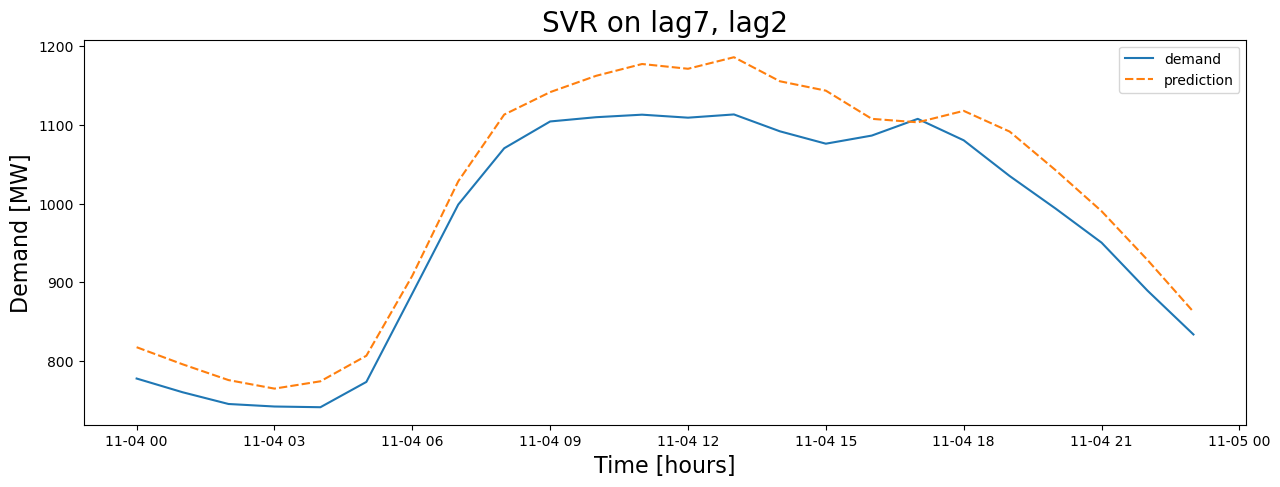

In [33]:
model = LinearSVR()
model.fit(X_train,y_train.values.ravel())

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("SVR on lag7, lag2", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

mape = mean_absolute_percentage_error(y_test, predictions_vector)*100
print("MAPE: %.3f" % mape)

# Add a new row (new model result)
results["SVR on lag7, lag2"] = {"MAPE": mape}

### Features: lag7, lag2, temperature

In [34]:
X_test = testing_vector[['lag7', 'lag2', 'T']]
y_test = testing_vector[['demand']]

X_train = training_vector[['lag7', 'lag2', 'T']]
y_train = training_vector[['demand']]

MAPE: 1.517


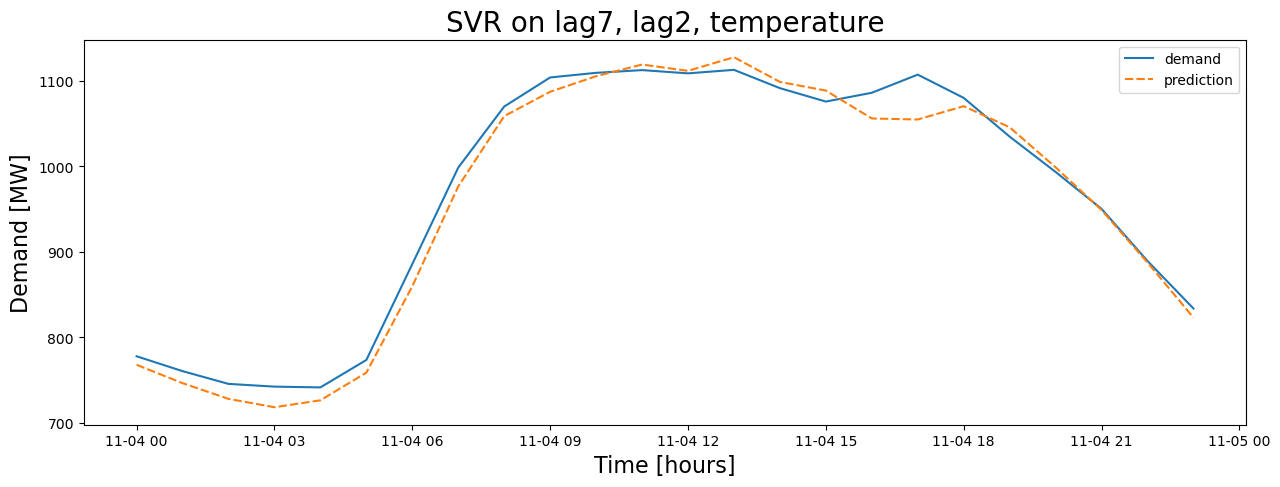

In [35]:
model = LinearSVR()
model.fit(X_train,y_train.values.ravel())

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(15,5))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("SVR on lag7, lag2, temperature", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

mape = mean_absolute_percentage_error(y_test, predictions_vector)*100
print("MAPE: %.3f" % mape)

# Add a new row (new model result)
results["SVR on lag7, lag2, temperature"] = {"MAPE": mape}

# 7️⃣ Evaluation 📊

To judge how well our models forecast electricity demand, we need **error metrics**.
Different metrics highlight different aspects of performance.

---
## Metrics
### 📏 Mean Absolute Error (MAE)

$$
MAE = \frac{1}{n}\sum |y - \hat{y}|
$$

* Measures the **average absolute difference** between actual ($y$) and predicted ($\hat{y}$) values.
* Interpretable in the same unit as the data (e.g., MW).
* **Good for:** a general sense of typical error.
* ⚡ Example: *MAE = 50 → on average, we miss by 50 MW.*

---

### 📐 Root Mean Squared Error (RMSE)

$$
RMSE = \sqrt{\frac{1}{n}\sum (y - \hat{y})^2}
$$

* Similar to MAE but **squares the errors** before averaging.
* Penalizes **large errors** more strongly.
* **Good for:** when big mistakes (e.g., missing peak demand) are very costly.
* ⚡ Example: *RMSE = 80 → typical large deviations are around 80 MW.*

---

### 📊 Mean Absolute Percentage Error (MAPE)

$$
MAPE = \frac{100}{n}\sum \left|\frac{y - \hat{y}}{y}\right|
$$

* Expresses error as a **percentage of actual demand**.
* Easy to interpret across scales.
* **Caution:** unstable when $y$ is very close to 0 (denominator issue).
* ⚡ Example: *MAPE = 5% → on average, forecasts are off by 5%.*

---

## 🔎 Why use multiple metrics?

* **MAE** → tells you the typical error.
* **RMSE** → warns about large errors (peaks).
* **MAPE** → expresses error in relative terms (easy for managers to understand).

👉 For energy forecasting, **operators often prefer MAPE** for communication, while **MAE/RMSE** are used by data scientists to fine-tune models.



---

## 📊 Interpreting the Results Table


In [36]:
# Convert to DataFrame
results_df = pd.DataFrame(results).T.round(2)
results_df.index.name = "Model"
results_df

,MAPE
Model,
Planned vs.actual,2.42
Naive model,1.55
Linear regression on lag7,1.79
"Linear regression on lag7, lag2",1.35
"Linear regression on lag7, lag2, temperature",2.34
SVR on lag7,6.26
"SVR on lag7, lag2",4.22
"SVR on lag7, lag2, temperature",1.52



### 🔎 Observations

* ✅ **Naive model (lag7)** already performs quite well.
* ✅ **Linear regression with lag7 + lag2** is the best overall, showing the value of combining **weekly** and **daily recency** effects.
* ⚠️ Adding **temperature** unexpectedly makes regression worse. 

* ⚠️ **SVR results are unstable**.
    * This indicates a need for **better feature scaling**, **parameter tuning (C, ε, γ)**, or more careful **cross-validation**.

---

### 💡 Takeaways

1. **Baselines are strong** → even simple lag-based models are hard to beat in short-term load forecasting.
2. **Linear models work well** → especially with well-chosen lag features.
3. **Weather needs care** → linear regression may not capture non-linear heating/cooling effects. Polynomial features or more flexible models may be needed.
4. **SVR requires tuning** → default settings can lead to very poor forecasts. With hyperparameter optimization, performance might improve.

---

👉 For practical forecasting, the **linear regression with lag7 + lag2** model is currently the most reliable in this experiment.